In [1]:
import torch
import torch.nn as nn
from models.tiny import resnet18
import os
from victim.blackbox import Blackbox
import utils.common as common
from datasets import sized_transforms
import numpy as np
import time
import copy
from torchvision import transforms

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
# pretrained = "/mnt/ywb/checkpoints/imagenet/resnet18/resnet18-5c106cde.pth"

model = resnet18()
# checkpoint = torch.load(pretrained)
# pretrained_state_dict = checkpoint.get("state_dict", checkpoint)
# model.load_state_dict(checkpoint)


In [3]:
device = torch.device('cuda')

In [4]:
from datasets.imagenet64 import ImageNet64 as imagenet
transform = transforms.Compose([
        transforms.Resize([32,32]),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
pretrained_data = imagenet(train=True, transform=transform)
pretrained_test_data = imagenet(train=False, transform=transform)




NameError: name 'pretrained_test_D' is not defined

In [7]:
dataloaders = {
    'train': torch.utils.data.DataLoader(
        pretrained_data,
        batch_size=64,
        shuffle=True,
        num_workers=4
    ),
    'val': torch.utils.data.DataLoader(
        pretrained_test_data,
        batch_size=64,
        shuffle=True,
        num_workers=4
    ),
}

In [8]:
def train_pretrained_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                if phase == 'val':
                    running_corrects += torch.sum(preds == labels.data)
                else:
                    running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

In [10]:
model = train_pretrained_model(model.cuda(), criterion, optimizer, lr_scheduler, num_epochs=100)

Epoch 0/99
----------


RuntimeError: CUDA error: device-side assert triggered
Exception raised from launch_vectorized_kernel at /pytorch/aten/src/ATen/native/cuda/CUDALoops.cuh:146 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7fe07e5cb1e2 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: void at::native::gpu_kernel_impl<__nv_hdl_wrapper_t<false, false, __nv_dl_tag<void (*)(at::TensorIterator&, c10::Scalar), &at::native::add_kernel_cuda, 4u>, float (float, float), float> >(at::TensorIterator&, __nv_hdl_wrapper_t<false, false, __nv_dl_tag<void (*)(at::TensorIterator&, c10::Scalar), &at::native::add_kernel_cuda, 4u>, float (float, float), float> const&) + 0xe03 (0x7fe032bb9933 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #2: void at::native::gpu_kernel<__nv_hdl_wrapper_t<false, false, __nv_dl_tag<void (*)(at::TensorIterator&, c10::Scalar), &at::native::add_kernel_cuda, 4u>, float (float, float), float> >(at::TensorIterator&, __nv_hdl_wrapper_t<false, false, __nv_dl_tag<void (*)(at::TensorIterator&, c10::Scalar), &at::native::add_kernel_cuda, 4u>, float (float, float), float> const&) + 0x11b (0x7fe032bbb34b in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #3: void at::native::gpu_kernel_with_scalars<__nv_hdl_wrapper_t<false, false, __nv_dl_tag<void (*)(at::TensorIterator&, c10::Scalar), &at::native::add_kernel_cuda, 4u>, float (float, float), float> >(at::TensorIterator&, __nv_hdl_wrapper_t<false, false, __nv_dl_tag<void (*)(at::TensorIterator&, c10::Scalar), &at::native::add_kernel_cuda, 4u>, float (float, float), float> const&) + 0xeb (0x7fe032bbb5bb in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0x192a486 (0x7fe032b7d486 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #5: at::native::add_kernel_cuda(at::TensorIterator&, c10::Scalar) + 0x1a (0x7fe032b7e1fa in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xbce25e (0x7fe068a0d25e in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: at::native::add_out(at::Tensor&, at::Tensor const&, at::Tensor const&, c10::Scalar) + 0x71 (0x7fe068a03b61 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xf3b932 (0x7fe03218e932 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cuda.so)
frame #9: <unknown function> + 0x2e9fad8 (0x7fe06acdead8 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #10: <unknown function> + 0x3377258 (0x7fe06b1b6258 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #11: torch::autograd::AccumulateGrad::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x38a (0x7fe06b1b7aaa in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0x3375bb7 (0x7fe06b1b4bb7 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #13: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7fe06b1b0400 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #14: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7fe06b1b0fa1 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #15: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7fe06b1a9119 in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #16: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7fe07f37dc8a in /home/ubuntu/torchenv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #17: <unknown function> + 0xbd6df (0x7fe09ac516df in /usr/lib/x86_64-linux-gnu/libstdc++.so.6)
frame #18: <unknown function> + 0x76db (0x7fe0a32b66db in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #19: clone + 0x3f (0x7fe0a283aa3f in /lib/x86_64-linux-gnu/libc.so.6)


In [4]:
device = torch.device('cuda')
for param in model.parameters():
   param.requires_grad=False
model.fc = nn.Linear(64, 43)
model = model.to(torch.device('cuda'))

In [5]:
blackbox = Blackbox.from_modeldir('/mnt/ywb/results/victim/gtsrb-blackbox')

=> loading checkpoint '/mnt/ywb/results/victim/gtsrb-blackbox/checkpoint.pth.tar'
=> loaded checkpoint (epoch 56, acc=97.81)


In [7]:
from datasets.gtsrb import GTSRB
test_data = GTSRB(train=False)

=> done loading GTSRB (test) with 12630 examples


In [8]:
test = common.query_dataset(blackbox, test_data, batch_size=64,device=torch.device('cuda'), transform=sized_transforms[32])
test.labels = [label.argmax() for label in test.labels]

100%|██████████| 12630/12630 [00:02<00:00, 4633.90it/s]


In [9]:
selected_labels = set()
selected_indices = []
for index, (_, label) in enumerate(data):
    if label not in selected_labels:
        selected_labels.add(label)
        selected_indices.append(index)
    if len(selected_labels) >= 1000:
        break


In [10]:
len(selected_indices)

1000

In [11]:
trainset = common.query_dataset(blackbox, data, list_indices=selected_indices,batch_size=64, device=torch.device('cuda'), transform=sized_transforms[32],)

100%|██████████| 1000/1000 [00:01<00:00, 868.10it/s]


In [19]:
from torchvision import transforms
trainset.dataset.dataset.transform = transforms.Compose([
        transforms.Resize([32,32]),
        
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
test.dataset.transform = transforms.Compose([
        transforms.Resize([32,32]),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [21]:
dataloaders = {
    'train': torch.utils.data.DataLoader(
        trainset,
        batch_size=64,
        shuffle=True,
        num_workers=4
    ),
    'val': torch.utils.data.DataLoader(
        test,
        batch_size=64,
        shuffle=True,
        num_workers=4
    ),
}

def train_model(model, train_criterion, test_criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                for layer in model.modules():
                    if isinstance(layer, nn.BatchNorm2d):
                        layer.eval()
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss = train_criterion(outputs, labels)
                    else:
                        loss = test_criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                if phase == 'val':
                    running_corrects += torch.sum(preds == labels.data)
                else:
                    running_corrects += torch.sum(preds == labels.argmax(1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
dataset_sizes = {'train': 1000, 'val': len(test)}

In [23]:
def SCE(input, target):
    log_probs = torch.nn.functional.log_softmax(input, dim=1)
    return -(target * log_probs).sum() / input.shape[0]

train_criterion = SCE

In [26]:
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-2, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

In [27]:
model = train_model(model, train_criterion, criterion, optimizer, lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 3.0727 Acc: 0.2640
val Loss: 3.7173 Acc: 0.0565

Epoch 1/99
----------
train Loss: 3.0639 Acc: 0.2640
val Loss: 3.7392 Acc: 0.0565

Epoch 2/99
----------
train Loss: 3.0578 Acc: 0.2640
val Loss: 3.7372 Acc: 0.0565

Epoch 3/99
----------
train Loss: 3.0532 Acc: 0.2640


KeyboardInterrupt: 

<BarContainer object of 43 artists>

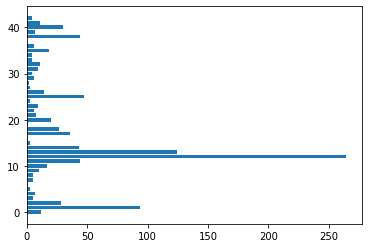

In [159]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.barh(range(43), y)

In [158]:
x = list(range(1000))
y = np.zeros(43)
for _, label in trainset:
    y[label.argmax()] += 1

In [76]:
torch.stack([trainset[0][1], trainset[1][1]]).argmax(1)

tensor([12,  2])

In [141]:
type(trainset.dataset)

utils.common.Subset

In [93]:
temp

[tensor([[-0.5734,  2.5447,  1.1931,  ...,  0.9234, -0.0713,  0.0810],
         [-0.3074,  1.6158,  0.4346,  ...,  0.8405, -0.5293,  0.0873],
         [ 0.2750,  1.4432,  1.5153,  ...,  1.0456, -0.2387,  0.7027],
         ...,
         [ 0.7430,  2.2944,  0.2418,  ...,  0.7948, -0.2294, -0.3633],
         [ 0.4993,  1.2861,  0.8116,  ...,  0.9104,  0.1671, -0.2291],
         [-0.0836,  2.0858,  1.0087,  ...,  0.5940, -0.4848,  0.0553]],
        device='cuda:0')]

In [101]:
temp[0].shape

torch.Size([64, 43])

In [100]:
temp[1].shape

torch.Size([64, 43])

In [103]:
test[0]

(tensor([[[-0.1486, -0.1486, -0.1486,  ..., -0.0629, -0.0458, -0.0458],
          [-0.1657, -0.1657, -0.1657,  ..., -0.0458, -0.0458, -0.0458],
          [-0.1828, -0.1828, -0.1828,  ..., -0.0458, -0.0458, -0.0458],
          ...,
          [-0.1314, -0.1314, -0.1143,  ..., -0.1486, -0.1486, -0.1486],
          [-0.1314, -0.1314, -0.1143,  ..., -0.1486, -0.1486, -0.1486],
          [-0.1314, -0.1314, -0.1314,  ..., -0.1486, -0.1314, -0.1314]],
 
         [[ 0.4153,  0.4153,  0.4153,  ...,  0.4678,  0.4678,  0.4678],
          [ 0.3978,  0.3978,  0.4153,  ...,  0.4853,  0.4853,  0.4853],
          [ 0.3978,  0.3978,  0.3978,  ...,  0.4853,  0.4853,  0.4853],
          ...,
          [ 0.3277,  0.3277,  0.3277,  ...,  0.3627,  0.3452,  0.3452],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.3627,  0.3452,  0.3452],
          [ 0.3102,  0.3102,  0.3102,  ...,  0.3452,  0.3452,  0.3452]],
 
         [[ 1.2108,  1.2108,  1.2108,  ...,  1.3154,  1.3154,  1.3154],
          [ 1.2108,  1.2108,